## Imports

In [ ]:
!git clone https://github.com/rmnigm/qber-forecasting.git

fatal: destination path 'qber-forecasting' already exists and is not an empty directory.


In [ ]:
!pip install catboost

In [ ]:
import collections
import math
import os
import pathlib
import random


import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as sps

import statsmodels as sm

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler

from tqdm.notebook import tqdm
from xgboost import XGBRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Data

In [ ]:
import pandas as pd

In [ ]:
cols_str = """
| block_id | frame_idx | E_mu_Z | E_mu_phys_est | E_mu_X | E_nu1_X | E_nu2_X| E_nu1_Z | E_nu2_Z |
| N_mu_X | M_mu_XX | M_mu_XZ | M_mu_X |
| N_mu_Z | M_mu_ZZ | M_mu_Z | N_nu1_X | M_nu1_XX | M_nu1_XZ | M_nu1_X | N_nu1_Z | M_nu1_ZZ | M_nu1_Z |
| N_nu2_X | M_nu2_XX | M_nu2_XZ | M_nu2_X | N_nu2_Z | M_nu2_ZZ | M_nu2_Z |
| nTot | bayesImVoltage | opticalPower | polarizerVoltages[0] | polarizerVoltages[1] | polarizerVoltages[2] | polarizerVoltages[3] |
| temp_1 | biasVoltage_1 | temp_2 | biasVoltage_2 | synErr |
| N_EC_rounds | maintenance_flag | estimator_name | f_EC | E_mu_Z_est | R | s | p
"""

columns = list(filter(lambda x: x, cols_str.replace(' ', '').replace('\n', '').split('|')))

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/qber/frames_errors_hw_info_2.csv', header=None)

In [ ]:
df.columns = columns

In [ ]:
interesting_columns = [
    'E_mu_Z',
    'E_mu_phys_est',
    'E_mu_X',
    'E_nu1_X',
    'E_nu1_Z',
    'E_nu2_Z',
    'N_mu_X',
    'M_mu_XX',
    'M_mu_XZ',
    'M_mu_X',
    'N_mu_Z',
    'M_mu_Z',
    'N_nu1_X',
    'M_nu1_XX',
    'M_nu1_XZ',
    'M_nu1_X',
    'N_nu1_Z',
    'M_nu1_ZZ',
    'M_nu1_Z',
    'N_nu2_X',
    'N_nu2_Z',
    'bayesImVoltage',
    'opticalPower',
    'polarizerVoltages[0]',
    'polarizerVoltages[1]',
    'polarizerVoltages[2]',
    'polarizerVoltages[3]',
]

In [ ]:
data = df[interesting_columns]

In [ ]:
import warnings

In [ ]:
n_lags = 10

def build_dataset(data):
    dataset = data.copy()
    variable_names = dataset.columns
    variable_names = list(filter(lambda x: x != 'E_mu_Z', variable_names))

    dataset['target'] = dataset['E_mu_Z'].shift(-1)

    dataset = dataset.join(dataset[variable_names].shift(1), rsuffix=f'-latest_value')
    variable_names += ["E_mu_Z"]

    for i in range(0, n_lags):
        dataset[f'lag_{i + 1}_E_mu_Z'] = dataset['E_mu_Z'].shift(i)

    for ws in [5, 10, 20, 30, 60]:
        roll_mean = dataset[variable_names].rolling(window=ws).mean()
        roll_std = dataset[variable_names].rolling(window=ws).std()
        dataset = dataset.join(roll_mean, rsuffix=f'-{ws}_rolling_mean')
        dataset = dataset.join(roll_std, rsuffix=f'-{ws}_rolling_std')

    dataset = dataset.join(dataset[variable_names].ewm(alpha=0.33).mean(), rsuffix=f'-ewm33_mean')
    dataset = dataset.join(dataset[variable_names].ewm(alpha=0.33).std(), rsuffix=f'-ewm33_std')
    dataset = dataset.join(dataset[variable_names].ewm(alpha=0.5).mean(), rsuffix=f'-ewm50_mean')
    dataset = dataset.join(dataset[variable_names].ewm(alpha=0.5).std(), rsuffix=f'-ewm50_std')

    dataset = dataset.dropna()


    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for var in filter(lambda x: x != 'E_mu_Z', variable_names):
            dataset[f"{var}-ewm33_diff"] = dataset[f"{var}-latest_value"] - dataset[f"{var}-ewm33_mean"]
            dataset[f"{var}-ewm50_diff"] = dataset[f"{var}-latest_value"] - dataset[f"{var}-ewm50_mean"]
            dataset[f"{var}-5_rolling_diff"] = dataset[f"{var}-latest_value"] - dataset[f"{var}-5_rolling_mean"]
            dataset[f"{var}-30_rolling_diff"] = dataset[f"{var}-latest_value"] - dataset[f"{var}-30_rolling_mean"]
            dataset[f"{var}-60_rolling_diff"] = dataset[f"{var}-latest_value"] - dataset[f"{var}-60_rolling_mean"]

        dataset = dataset.drop(columns=variable_names)
        dataset = dataset.fillna(0)
        dataset = dataset.copy()

    X = dataset.drop(columns='target')
    y = dataset['target']
    return X, y

## Modelling

In [ ]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.kernel_ridge import KernelRidge

from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
X, y = build_dataset(data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model = Ridge(max_iter=500)

model.fit(X_train, y_train)

preds = model.predict(X_train)
print(r2_score(y_train, preds))

preds = model.predict(X_test)
print(r2_score(y_test, preds))

0.9575827909864533
0.4762247873979666


In [ ]:
from catboost import Pool, EShapCalcType, EFeaturesSelectionAlgorithm
model = CatBoostRegressor(
    iterations=2000,
    early_stopping_rounds=500,
    task_type='GPU',
    devices='0',
    verbose=False,
    )

summary = model.select_features(
    Pool(X_train, y_train),
    eval_set=Pool(X_test, y_test),
    features_for_select=f'0-{X_test.shape[1] - 1}',
    num_features_to_select=40,
    steps=4,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
selected_features = summary["selected_features_names"]

In [ ]:
model = Ridge(max_iter=500, alpha=0.5)

model.fit(X_train[selected_features], y_train)

preds = model.predict(X_train[selected_features])
print(r2_score(y_train, preds))

preds = model.predict(X_test[selected_features])
print(r2_score(y_test, preds))

0.9566084640355328
0.5718218562316899


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.45243e-18): result may not be accurate.



In [ ]:
full_model = CatBoostRegressor(
    iterations=2000,
    early_stopping_rounds=500,
    task_type='GPU',
    devices='0',
    verbose=False,
    )


full_model.fit(X_train[selected_features], y_train,
          eval_set=(X_test[selected_features], y_test))

In [ ]:
preds = full_model.predict(X_train[selected_features])
print(r2_score(y_train, preds))

preds = full_model.predict(X_test[selected_features])
print(r2_score(y_test, preds))

0.9721686162077562
0.6207564554603344


In [ ]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def fe_by_batch(model, X, y, n=30000):
    metrics, importances = [], []
    for X_subset, y_subset in zip(batch(X, n), batch(y, n)):
        pool = Pool(X_subset[selected_features], y_subset)
        fe = model.get_feature_importance(pool, prettified=True)
        metrics.append(r2_score(y_subset, model.predict(pool)))
        importances.append(list(fe["Feature Id"]))
    importances = pd.DataFrame(importances).T
    importances.columns = [f"batch {i}" for i in range(0, len(X), n)]
    return importances, metrics

In [ ]:
train_importances, train_metrics = fe_by_batch(full_model, X_train, y_train, n=40000)
test_importances, _ = fe_by_batch(full_model, X_test, y_test, n=40000)

In [ ]:
train_importances

,batch 0,batch 40000,batch 80000,batch 120000,batch 160000,batch 200000,batch 240000
0,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z
1,M_nu1_Z-ewm33_mean,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z
2,M_nu1_Z-30_rolling_mean,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_2_E_mu_Z,lag_3_E_mu_Z
3,M_nu1_Z-latest_value,E_mu_Z-60_rolling_mean,E_mu_Z-60_rolling_mean,E_mu_Z-60_rolling_mean,E_mu_Z-60_rolling_mean,lag_3_E_mu_Z,lag_2_E_mu_Z
4,lag_10_E_mu_Z,E_mu_Z-ewm50_mean,lag_2_E_mu_Z,lag_2_E_mu_Z,lag_2_E_mu_Z,E_mu_Z-60_rolling_mean,E_mu_Z-60_rolling_mean
5,M_mu_XZ-ewm33_std,lag_2_E_mu_Z,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean
6,E_mu_phys_est-ewm33_mean,E_mu_Z-30_rolling_mean,E_mu_Z-30_rolling_mean,E_mu_Z-20_rolling_std,E_mu_Z-10_rolling_std,E_mu_Z-30_rolling_mean,E_mu_Z-10_rolling_std
7,E_nu1_Z-10_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_Z-30_rolling_mean,E_nu1_Z-10_rolling_mean,E_mu_Z-20_rolling_std
8,E_mu_phys_est-60_rolling_mean,E_mu_Z-10_rolling_std,E_nu1_Z-10_rolling_mean,E_mu_Z-10_rolling_std,E_mu_Z-20_rolling_std,E_mu_phys_est-60_rolling_mean,E_mu_phys_est-60_rolling_mean
9,E_mu_phys_est-20_rolling_mean,E_mu_Z-30_rolling_std,E_mu_Z-10_rolling_std,E_mu_Z-30_rolling_mean,E_mu_Z-30_rolling_std,E_mu_Z-30_rolling_std,M_nu1_XZ-60_rolling_mean


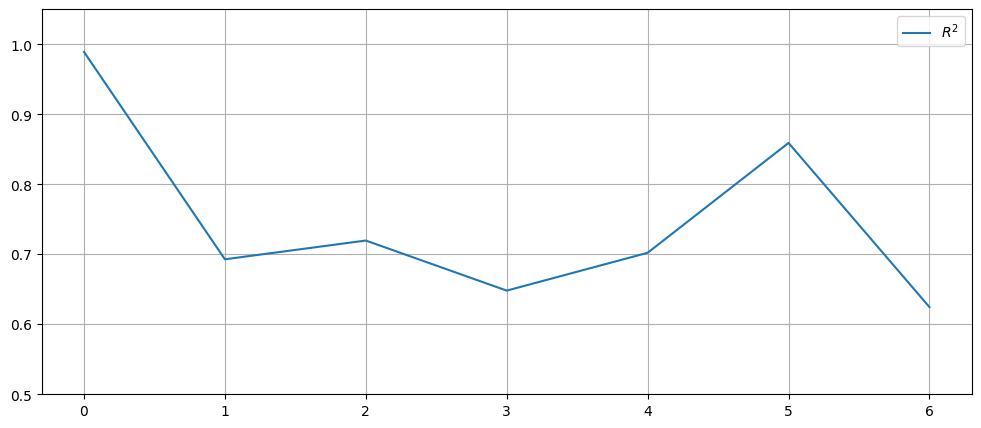

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(train_metrics, label="$R^2$")
plt.ylim(0.5, 1.05)
plt.grid()
plt.legend()
plt.show()

### first half

In [80]:
X, y = build_dataset(data[:165000])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
model = CatBoostRegressor(
    iterations=2000,
    early_stopping_rounds=500,
    task_type='GPU',
    devices='0',
    verbose=False,
    )


model.fit(X_train[selected_features], y_train,
          eval_set=(X_test[selected_features], y_test))

preds = model.predict(X_train[selected_features])
print(r2_score(y_train, preds))

preds = model.predict(X_test[selected_features])
print(r2_score(y_test, preds))

train_importances, train_metrics = fe_by_batch(model, X_train, y_train, n=15000)
test_importances, _ = fe_by_batch(model, X_test, y_test, n=15000)

0.9897787741762127
0.6958013781800471


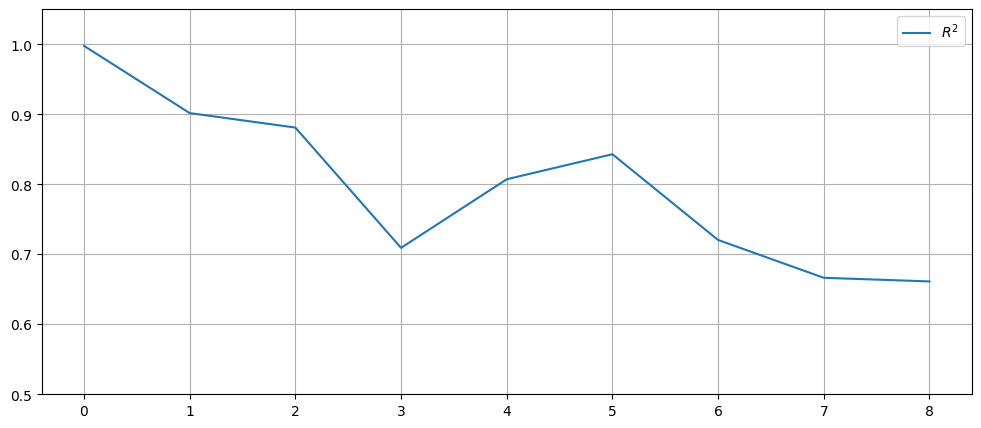

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(train_metrics, label="$R^2$")
plt.ylim(0.5, 1.05)
plt.grid()
plt.legend()
plt.show()

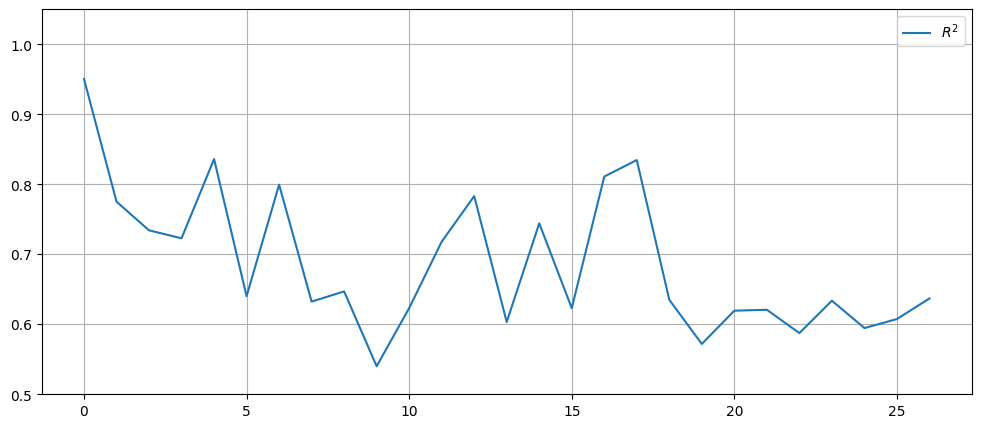

In [81]:
train_importances, train_metrics = fe_by_batch(full_model, X_train, y_train, n=5000)

plt.figure(figsize=(12, 5))
plt.plot(train_metrics, label="$R^2$")
plt.ylim(0.5, 1.05)
plt.grid()
plt.legend()
plt.show()

In [82]:
train_importances

,batch 0,batch 5000,batch 10000,batch 15000,batch 20000,batch 25000,batch 30000,batch 35000,batch 40000,batch 45000,...,batch 85000,batch 90000,batch 95000,batch 100000,batch 105000,batch 110000,batch 115000,batch 120000,batch 125000,batch 130000
0,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,...,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z
1,E_mu_phys_est-ewm33_mean,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,...,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z
2,E_mu_phys_est-20_rolling_mean,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_2_E_mu_Z,lag_3_E_mu_Z,E_nu1_Z-10_rolling_mean,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,...,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z,lag_3_E_mu_Z
3,E_mu_phys_est-60_rolling_mean,E_mu_Z-60_rolling_mean,lag_2_E_mu_Z,lag_2_E_mu_Z,E_mu_Z-ewm50_mean,E_mu_Z-60_rolling_mean,lag_3_E_mu_Z,E_mu_Z-60_rolling_mean,E_mu_Z-ewm50_mean,lag_2_E_mu_Z,...,E_mu_Z-ewm50_mean,E_mu_Z-60_rolling_mean,E_mu_Z-60_rolling_mean,E_mu_Z-60_rolling_mean,lag_2_E_mu_Z,lag_2_E_mu_Z,lag_2_E_mu_Z,lag_2_E_mu_Z,lag_2_E_mu_Z,E_mu_Z-ewm50_mean
4,E_nu1_Z-10_rolling_mean,E_mu_Z-ewm50_mean,E_mu_Z-60_rolling_mean,E_mu_Z-60_rolling_mean,lag_3_E_mu_Z,lag_2_E_mu_Z,lag_2_E_mu_Z,E_mu_Z-ewm50_mean,E_mu_Z-60_rolling_mean,E_mu_Z-ewm50_mean,...,lag_2_E_mu_Z,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean,E_mu_Z-20_rolling_std,E_mu_Z-60_rolling_mean,E_mu_Z-60_rolling_mean,E_mu_Z-ewm50_mean,E_mu_Z-60_rolling_mean
5,M_mu_XZ-ewm33_std,lag_2_E_mu_Z,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean,E_mu_Z-30_rolling_mean,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean,lag_2_E_mu_Z,lag_2_E_mu_Z,E_mu_Z-60_rolling_mean,...,E_mu_Z-60_rolling_mean,lag_2_E_mu_Z,lag_2_E_mu_Z,lag_2_E_mu_Z,E_mu_Z-60_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_Z-ewm50_mean,E_mu_Z-20_rolling_std,E_mu_Z-60_rolling_mean,lag_2_E_mu_Z
6,polarizerVoltages[0]-60_rolling_mean,M_mu_XZ-ewm33_std,E_mu_Z-10_rolling_std,E_mu_Z-30_rolling_std,E_mu_Z-60_rolling_mean,E_mu_Z-10_rolling_std,E_mu_Z-60_rolling_mean,E_mu_Z-30_rolling_mean,E_mu_Z-30_rolling_mean,E_mu_phys_est-60_rolling_mean,...,E_mu_Z-30_rolling_mean,E_mu_Z-30_rolling_mean,E_mu_Z-30_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_Z-ewm50_mean,E_mu_Z-20_rolling_std,E_mu_phys_est-60_rolling_mean,E_mu_Z-20_rolling_std,E_mu_Z-20_rolling_std
7,E_mu_Z-ewm50_mean,E_mu_Z-30_rolling_mean,E_mu_Z-30_rolling_std,E_mu_Z-20_rolling_std,E_nu1_Z-latest_value,E_mu_phys_est-60_rolling_mean,M_nu1_Z-ewm33_mean,E_mu_Z-20_rolling_std,E_mu_Z-20_rolling_std,E_mu_Z-30_rolling_std,...,E_mu_Z-10_rolling_std,E_mu_Z-20_rolling_std,M_nu1_Z-ewm33_mean,E_mu_Z-30_rolling_mean,E_mu_Z-20_rolling_std,E_mu_Z-60_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_Z-ewm50_mean,E_mu_phys_est-60_rolling_mean,E_mu_phys_est-60_rolling_mean
8,E_mu_Z-30_rolling_std,M_mu_XX-ewm50_mean,E_mu_Z-30_rolling_mean,E_mu_Z-30_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_Z-20_rolling_std,E_mu_phys_est-60_rolling_mean,E_mu_Z-10_rolling_std,E_mu_phys_est-60_rolling_mean,E_mu_Z-20_rolling_std,...,E_mu_Z-20_rolling_std,E_mu_Z-10_rolling_std,E_mu_Z-30_rolling_std,E_mu_Z-20_rolling_std,E_mu_Z-10_rolling_std,E_mu_Z-10_rolling_std,E_mu_Z-30_rolling_mean,E_mu_Z-10_rolling_std,E_mu_Z-10_rolling_std,E_mu_Z-30_rolling_mean
9,E_mu_Z-10_rolling_std,E_mu_phys_est-60_rolling_mean,E_mu_Z-20_rolling_std,E_mu_Z-10_rolling_std,polarizerVoltages[0]-60_rolling_mean,N_nu2_Z-5_rolling_mean,E_mu_Z-30_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_Z-10_rolling_std,E_mu_Z-10_rolling_std,...,M_mu_XX-ewm50_mean,M_mu_XX-ewm50_mean,E_mu_Z-20_rolling_std,E_mu_Z-10_rolling_std,E_mu_

### second half

In [ ]:
X, y = build_dataset(data[165000:])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = CatBoostRegressor(
    iterations=2000,
    early_stopping_rounds=500,
    task_type='GPU',
    devices='0',
    verbose=False,
    )


model.fit(X_train[selected_features], y_train,
          eval_set=(X_test[selected_features], y_test))

preds = model.predict(X_train[selected_features])
print(r2_score(y_train, preds))

preds = model.predict(X_test[selected_features])
print(r2_score(y_test, preds))

0.8549914917016015
0.46170878407796


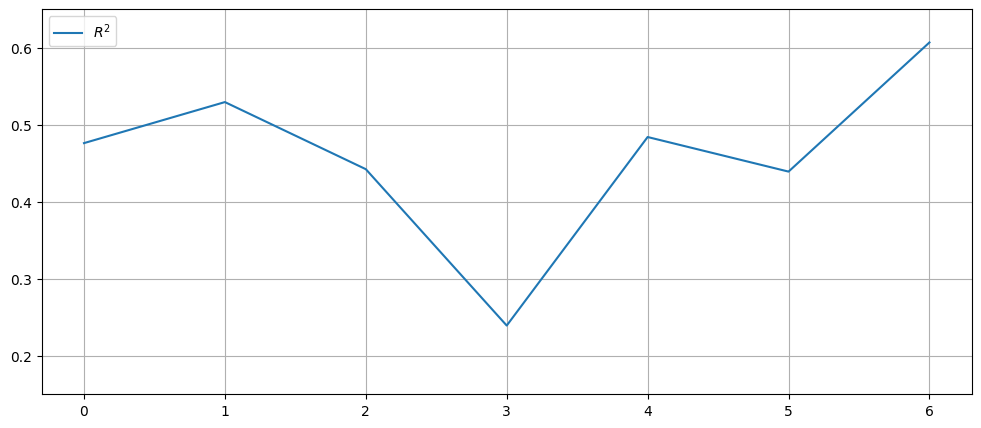

In [ ]:
test_importances, test_metrics = fe_by_batch(model, X_test, y_test, n=5000)

plt.figure(figsize=(12, 5))
plt.plot(test_metrics, label="$R^2$")
plt.ylim(0.15, 0.65)
plt.grid()
plt.legend()
plt.show()

In [ ]:
test_importances

,batch 0,batch 5000,batch 10000,batch 15000,batch 20000,batch 25000,batch 30000
0,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z
1,lag_10_E_mu_Z,E_nu1_Z-10_rolling_mean,lag_2_E_mu_Z,lag_2_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_3_E_mu_Z
2,lag_3_E_mu_Z,lag_10_E_mu_Z,E_mu_Z-ewm50_mean,E_mu_Z-30_rolling_std,lag_3_E_mu_Z,lag_3_E_mu_Z,M_nu1_ZZ-ewm33_mean
3,E_nu1_Z-60_rolling_diff,lag_3_E_mu_Z,lag_10_E_mu_Z,E_mu_Z-ewm50_mean,lag_2_E_mu_Z,lag_2_E_mu_Z,lag_10_E_mu_Z
4,lag_2_E_mu_Z,M_nu1_Z-30_rolling_mean,lag_3_E_mu_Z,E_mu_Z-60_rolling_mean,E_mu_Z-10_rolling_std,E_mu_Z-10_rolling_std,E_mu_Z-60_rolling_mean
5,E_mu_Z-60_rolling_mean,lag_2_E_mu_Z,E_mu_phys_est-ewm33_mean,lag_10_E_mu_Z,E_mu_Z-ewm50_mean,E_mu_Z-ewm50_mean,M_nu1_Z-ewm33_mean
6,M_mu_XX-ewm50_mean,E_mu_Z-ewm50_mean,E_mu_Z-60_rolling_mean,E_mu_phys_est-ewm33_mean,E_mu_Z-60_rolling_mean,E_mu_Z-30_rolling_std,lag_2_E_mu_Z
7,E_mu_Z-10_rolling_std,E_mu_Z-10_rolling_std,E_nu1_Z-10_rolling_mean,lag_3_E_mu_Z,E_mu_Z-30_rolling_std,E_mu_Z-20_rolling_std,E_mu_Z-ewm50_mean
8,M_nu1_XZ-60_rolling_mean,E_mu_Z-60_rolling_mean,E_nu1_Z-60_rolling_diff,M_nu1_Z-ewm33_mean,E_mu_Z-20_rolling_std,E_mu_Z-30_rolling_mean,E_mu_Z-30_rolling_mean
9,E_mu_Z-30_rolling_mean,E_mu_phys_est-60_rolling_mean,E_mu_Z-30_rolling_mean,M_nu1_ZZ-ewm33_mean,E_mu_Z-30_rolling_mean,E_mu_Z-60_rolling_mean,E_mu_Z-30_rolling_std


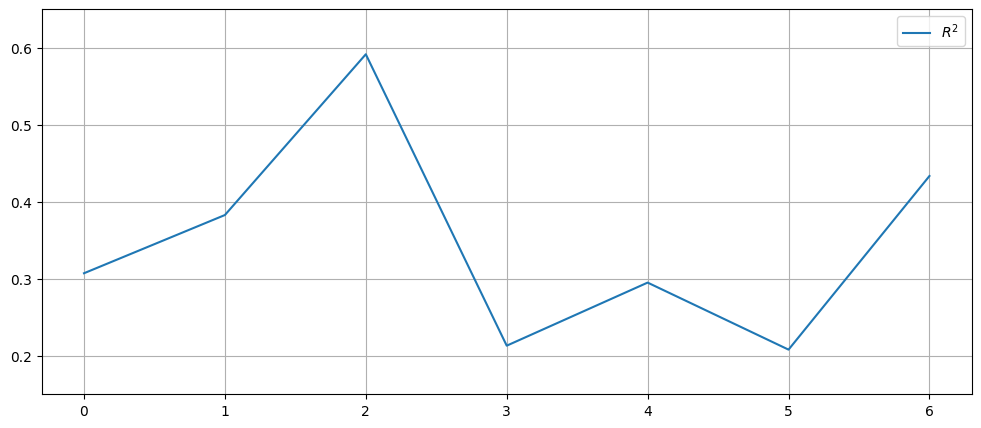

In [ ]:
test_importances, test_metrics = fe_by_batch(full_model, X_test, y_test, n=5000)

plt.figure(figsize=(12, 5))
plt.plot(test_metrics, label="$R^2$")
plt.ylim(0.15, 0.65)
plt.grid()
plt.legend()
plt.show()

In [ ]:
test_importances

,batch 0,batch 5000,batch 10000,batch 15000,batch 20000,batch 25000,batch 30000
0,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z,lag_1_E_mu_Z
1,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z,opticalPower-20_rolling_mean,opticalPower-20_rolling_mean,opticalPower-20_rolling_mean,E_mu_Z-60_rolling_mean
2,E_nu1_Z-20_rolling_std,opticalPower-20_rolling_mean,opticalPower-20_rolling_mean,lag_10_E_mu_Z,M_nu1_ZZ-5_rolling_diff,M_nu1_ZZ-5_rolling_diff,E_mu_Z-10_rolling_std
3,lag_3_E_mu_Z,M_nu1_ZZ-5_rolling_diff,E_nu1_Z-20_rolling_std,E_nu1_Z-20_rolling_std,lag_10_E_mu_Z,lag_10_E_mu_Z,lag_10_E_mu_Z
4,E_mu_Z-60_rolling_mean,lag_3_E_mu_Z,E_mu_Z-60_rolling_mean,M_nu1_ZZ-5_rolling_diff,lag_3_E_mu_Z,M_nu1_Z-ewm33_mean,opticalPower-20_rolling_mean
5,E_mu_Z-10_rolling_std,E_nu1_Z-20_rolling_std,M_nu1_ZZ-5_rolling_diff,E_mu_Z-10_rolling_std,E_nu1_Z-20_rolling_std,lag_3_E_mu_Z,lag_3_E_mu_Z
6,E_nu1_Z-60_rolling_mean,E_nu1_Z-60_rolling_mean,lag_3_E_mu_Z,E_mu_Z-60_rolling_mean,M_nu1_Z-ewm33_mean,E_mu_Z-10_rolling_std,M_nu1_ZZ-5_rolling_diff
7,E_mu_phys_est-60_rolling_mean,lag_2_E_mu_Z,E_mu_Z-10_rolling_std,lag_3_E_mu_Z,E_mu_Z-10_rolling_std,M_nu1_XZ-ewm50_mean,E_mu_Z-20_rolling_std
8,M_mu_Z-ewm50_mean,M_nu1_Z-ewm33_mean,E_mu_Z-30_rolling_mean,E_nu1_Z-10_rolling_mean,E_nu1_Z-10_rolling_mean,E_mu_phys_est-ewm33_mean,E_mu_Z-30_rolling_mean
9,M_nu1_XZ-60_rolling_mean,E_mu_Z-ewm50_mean,E_mu_Z-30_rolling_std,lag_2_E_mu_Z,lag_2_E_mu_Z,M_mu_XX-60_rolling_mean,lag_2_E_mu_Z


In [ ]:
selected_features

['E_nu1_Z-latest_value',
 'M_nu1_Z-latest_value',
 'polarizerVoltages[0]-latest_value',
 'lag_1_E_mu_Z',
 'lag_2_E_mu_Z',
 'lag_3_E_mu_Z',
 'lag_10_E_mu_Z',
 'N_nu2_Z-5_rolling_mean',
 'E_nu1_Z-10_rolling_mean',
 'M_mu_XZ-10_rolling_std',
 'E_mu_Z-10_rolling_std',
 'E_mu_phys_est-20_rolling_mean',
 'E_nu2_Z-20_rolling_mean',
 'M_mu_Z-20_rolling_mean',
 'M_nu1_XZ-20_rolling_mean',
 'opticalPower-20_rolling_mean',
 'E_nu1_Z-20_rolling_std',
 'E_mu_Z-20_rolling_std',
 'E_nu1_Z-30_rolling_mean',
 'M_nu1_Z-30_rolling_mean',
 'E_mu_Z-30_rolling_mean',
 'E_mu_Z-30_rolling_std',
 'E_mu_phys_est-60_rolling_mean',
 'E_nu1_Z-60_rolling_mean',
 'M_mu_XX-60_rolling_mean',
 'M_nu1_XZ-60_rolling_mean',
 'polarizerVoltages[0]-60_rolling_mean',
 'E_mu_Z-60_rolling_mean',
 'E_nu1_X-60_rolling_std',
 'E_mu_phys_est-ewm33_mean',
 'M_nu1_ZZ-ewm33_mean',
 'M_nu1_Z-ewm33_mean',
 'M_mu_XZ-ewm33_std',
 'M_mu_XX-ewm50_mean',
 'M_mu_Z-ewm50_mean',
 'M_nu1_XZ-ewm50_mean',
 'N_nu1_Z-ewm50_mean',
 'E_mu_Z-ewm50_mea